In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

import os
import pandas as pd
import skfmm

import gudhi as gd

In [2]:
def read_binary_img(filename, threshold=100):
    bimg = cv2.imread(filename)[:,:,0]
    bimg[bimg < threshold] = 0
    bimg[bimg > 0] = 1
    bimg = bimg.astype(bool)

    return bimg

def pers2numpy(pers):
    bd = np.zeros((len(pers), 3), dtype=float)
    for i in range(len(bd)):
        bd[i, 0] = pers[i][0]
        bd[i, 1:] = pers[i][1]
    return bd
    
def root_watershed(inv, gimg, main, rest, tips, tmask):
    watershed = np.zeros(inv.shape, dtype=np.uint8)
    colorval = 1
    colordict = dict()
    
    for ix in range(len(rest[tmask])-1, -1, -1):
        print('Iteration:\t', ix)
        thr = main[rest[tmask][ix,1]]
        timg = gimg*(inv < thr)
        
        label, nums = ndimage.label( timg, structure=ndimage.generate_binary_structure(2,1))
        print('Found',nums,'connected components.')
        hist, bins = np.histogram(label, bins=range(1,nums+2))
        hargsort = np.argsort(hist)[::-1]
        mainlabels = np.zeros(ix+1, dtype=int)
        for i in range(len(mainlabels)):
            foo = label[tuple(tips[tmask][i])]
            mainlabels[i] = foo-1
        mainlabels = mainlabels[mainlabels > -1]
        
        for i in range(len(mainlabels)):
            mask = (watershed == 0) & (label == mainlabels[i] + 1)
            watershed[mask] = colorval
            
            colorlist = []
            for j in range(len(tips[tmask])):
                if label[tuple(tips[tmask][j])] == mainlabels[i] + 1:
                    colorlist.append(rest[tmask][j,0])
            colordict[colorval] = colorlist
            colorval += 1

    return watershed, colordict

def get_birthdeath(img, vmax, thr=None):

    if thr is None:
        thr = (np.max(img) - np.min(img))/20
        
    BirthDeath = []
    
    label, nums = ndimage.label(img, structure=ndimage.generate_binary_structure(2,1))
    extrema = ndimage.extrema(img, label, index=range(1,nums+1))
    
    oslices = ndimage.find_objects(label)
    print('Found',nums,'connected components')

    lifespan = extrema[1] - extrema[0]
    lmask = lifespan > thr
    lzero = np.nonzero(lmask)[0]
    print('Thr:', np.round(thr), ':', len(lifespan), '--->', len(lzero), sep='\t')

    for k in range(len(lzero)):
        box = img[oslices[lzero[k]]].copy()
        box[label[oslices[lzero[k]]] != lzero[k] + 1] = 0
        inv = extrema[1][lzero[k]] - box
        
        cc = gd.CubicalComplex(top_dimensional_cells = inv)
        pers = cc.persistence(homology_coeff_field=2, min_persistence=10)

        bd = pers2numpy(pers)
        bd = np.atleast_2d(bd[np.all(bd < np.inf, axis=1), :]).squeeze()
        bd = bd[bd[:,0] == 0, 1:] + (vmax - extrema[1][lzero[k]])
        bd = np.vstack(([ vmax - extrema[1][lzero[k]] , vmax - extrema[0][lzero[k]] ], bd))
        BirthDeath.append(bd)

    BirthDeath.append(np.column_stack((extrema[0][~lmask & (lifespan > 10)], extrema[1][~lmask & (lifespan > 10)])))
    
    return BirthDeath

In [15]:
genotypes = ['CAL','MLB','222','299','517','521']
runnum = 1

src = '../run{:02d}/'.format(runnum)

psrc = src + 'processed/'
gsrc = src + 'gudhi/'
ddst = src + 'diagnostic/'
hdst = src + 'histograms/'

if not os.path.isdir(hdst):
    os.mkdir(hdst)

gidx = 2
bfiles = sorted(glob(psrc + '*{}*.npy'.format(genotypes[gidx])))
print('Total number of files:\t{}\n'.format(len(bfiles)))
for i in range(len(bfiles)):
    print(i, bfiles[i], sep='\t')

Total number of files:	8

0	../run01/processed/222F_side1_022817002_-_completed_binary_2066_3439_0_3976.npy
1	../run01/processed/222F_side1_030117010_-_completed_binary_845_4712_0_6296.npy
2	../run01/processed/222F_side2_022817003_-_completed_binary_2204_3773_0_4299.npy
3	../run01/processed/222F_side2_030117011_-_completed_binary_995_4710_0_6294.npy
4	../run01/processed/222M_side1_022817026_-_completed_binary_1436_4289_0_4602.npy
5	../run01/processed/222M_side1_030117006_-_completed_binary_1793_3646_0_2708.npy
6	../run01/processed/222M_side2_022817027_-_completed_binary_1329_3876_0_4497.npy
7	../run01/processed/222M_side2_030117007_-_completed_binary_1699_3557_0_2548.npy


In [17]:
idx = 5
bname = os.path.splitext(os.path.split(bfiles[idx])[1])[0].split('_-_')[0]
ceros = np.array(os.path.splitext(bfiles[idx])[0].split('_')[-4:], dtype=int)
zeroslice = np.s_[ceros[2]:ceros[3], ceros[0]:ceros[1]]

print(bfiles[idx], bname, sep='\n')
gimg = np.load(bfiles[idx], allow_pickle=True)

../run01/processed/222M_side1_030117006_-_completed_binary_1793_3646_0_2708.npy
222M_side1_030117006


# Make a proper geodesic watershed

In [18]:
m = np.copy(gimg)
m[0, gimg[0] ] = False
m = np.ma.masked_array(m, ~gimg)

gdt = skfmm.distance(m).data
inv = np.max(gdt) - gdt
main = np.ravel(inv, 'F')

filename = gsrc + bname + '_-_binary_H0.csv'
birthdeath = pd.read_csv(filename)
tips = birthdeath.loc[:, ['tipX','tipY']].values
merge = birthdeath.loc[:, ['endX', 'endY']].values
rest = birthdeath.loc[:, ['tipF','endF']].values

filename = gsrc + bname + '_-_root_tips.csv'
print(filename)
tmask = np.zeros(len(birthdeath), dtype=bool)
tmask[ np.atleast_1d(np.loadtxt(filename, delimiter=',', dtype=int)) ] = True
print('Found ', np.sum(tmask), ' root tips')

../run01/gudhi/222M_side1_030117006_-_root_tips.csv
Found  4  root tips


Iteration:	 3
Found 16 connected components.
Iteration:	 2
Found 17 connected components.
Iteration:	 1
Found 9 connected components.
Iteration:	 0
Found 1 connected components.


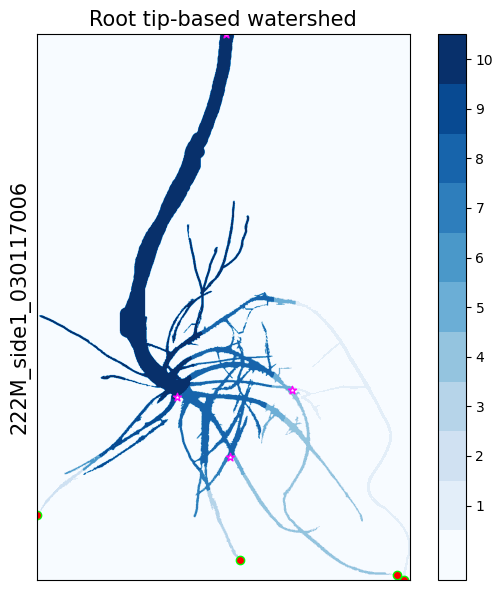

In [19]:
watershed, colordict = root_watershed(inv, gimg, main, rest, tips, tmask)
if True:
    fs = 15
    cmap = plt.get_cmap('Blues', len(colordict) + 1)
    
    fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    a = ax[0].imshow(watershed, cmap=cmap, origin='upper', vmin=-.5, vmax=len(colordict)+.5)
    ax[0].scatter(tips[tmask,1], tips[tmask,0], marker='o', color='r', edgecolor='lime', linewidth=1)
    ax[0].scatter(merge[tmask,1], merge[tmask,0], marker='*', color='white', edgecolor='magenta', linewidth=1)
    ax[0].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    ax[0].set_ylabel(bname, fontsize=fs)
    ax[0].set_title('Root tip-based watershed', fontsize=fs)
    cax = plt.colorbar(a, ticks=range(1, len(colordict) + 1))
    
    fig.tight_layout()
    
    filename = ddst + 'watershed_root_tip_-_' + bname
    plt.savefig(filename +'.png', format='png', bbox_inches='tight', dpi=200)

In [20]:
wshds = np.zeros((np.sum(tmask), gimg.shape[0], gimg.shape[1])) 
for i in range(len(wshds)):
    m = np.zeros_like(gimg)
    for key in colordict:
        if rest[tmask, 0][i] in colordict[key]:
            m[watershed == key] = True
    #m = ndimage.binary_dilation(m, ndimage.generate_binary_structure(2,2), 7)*gimg 
    foo = np.copy(m)
    m[tuple(tips[tmask][i])] = False
    m = np.ma.masked_array(m, ~foo)
    wshds[i] = skfmm.distance(m).data

    wshds[i][wshds[i] <= 0] = -2**16
    wshds[i][tuple(tips[tmask][i])] = 0

vmax = np.max(wshds)
wshds = np.abs(wshds)
rootw = np.min(wshds, axis=0)
rootw[rootw > 2**15] = 0

In [21]:
if False:
    fig, ax = plt.subplots(1,len(wshds), figsize=(3*len(wshds),6), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i in range(len(ax)):
        foo = wshds[i].copy()
        foo[foo > 2**15] = 0
        ax[i].imshow(foo, cmap='inferno', origin='upper', vmin=0, vmax=vmax)
        ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
        ax[i].scatter(tips[tmask,1][i], tips[tmask,0][i], marker='o', color='r', edgecolor='lime', linewidth=1)
        ax[i].scatter(merge[tmask,1][i], merge[tmask,0][i], marker='*', color='white', edgecolor='magenta', linewidth=1)
    
    ax[0].set_ylabel(bname, fontsize=fs)
    fig.tight_layout();
    
    filename = ddst + 'dict_watershed_root_tip_-_' + bname
    #plt.savefig(filename +'.png', format='png', bbox_inches='tight', dpi=200)

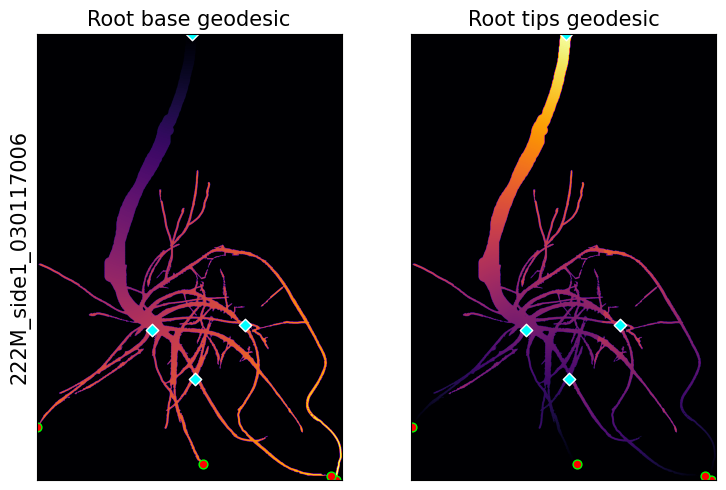

In [22]:
s = 40
fig, ax = plt.subplots(1,2, figsize=(8,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([gdt, rootw]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    ax[i].scatter(tips[tmask,1], tips[tmask,0], marker='o', color='r', edgecolor='lime', linewidth=1, s=s)
    ax[i].scatter(merge[tmask,1], merge[tmask,0], marker='D', color='cyan', edgecolor='w', linewidth=1, s=s)

i = 0
ax[i].set_ylabel(bname, fontsize=fs)
ax[i].set_title('Root base geodesic', fontsize=fs); i += 1
ax[i].set_title('Root tips geodesic', fontsize=fs)

fig.tight_layout();

In [23]:
foo = (gdt > 0) != (rootw > 0)
print(np.sum(foo))

4


# Compare healthy from diseased

In [24]:
imtype = ['Diseased', 'Healthy', 'Binary']
rimg = [ (read_binary_img(glob(src + '{}*/*{}*'.format(imtype[i], bname.replace('-','*')))[0], 25)[zeroslice])*gimg for i in range(2) ]

rgeod = [ gdt*rimg[i] for i in range(len(rimg)) ]
tgeod = [ rootw*rimg[i] for i in range(len(rimg)) ]

In [12]:
print('Rimg')
for i in [0,1]:
    label, nums = ndimage.label(rimg[i], structure=ndimage.generate_binary_structure(2,1))
    print('[',i,']\tFound',nums,'connected components')

print('--\nRgeod')
for i in [0,1]:
    label, nums = ndimage.label(rgeod[i], structure=ndimage.generate_binary_structure(2,1))
    print('[',i,']\tFound',nums,'connected components')

print('--\nTgeod')
for i in [0,1]:
    label, nums = ndimage.label(tgeod[i], structure=ndimage.generate_binary_structure(2,1))
    print('[',i,']\tFound',nums,'connected components')

Rimg
[ 0 ]	Found 2529 connected components
[ 1 ]	Found 1388 connected components
--
Rgeod
[ 0 ]	Found 2529 connected components
[ 1 ]	Found 1388 connected components
--
Tgeod
[ 0 ]	Found 2491 connected components
[ 1 ]	Found 1386 connected components


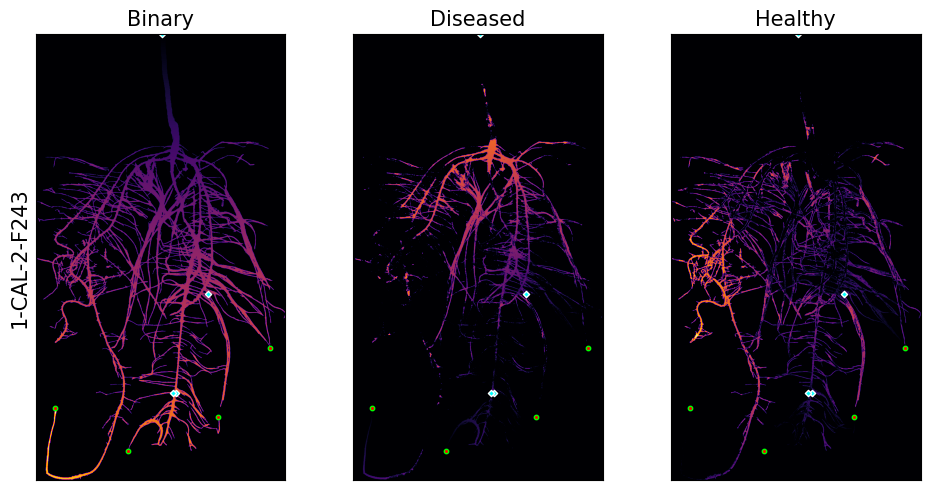

In [24]:
s = 10
fig, ax = plt.subplots(1,3, figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([gdt, *tgeod]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    ax[i].scatter(tips[tmask,1], tips[tmask,0], marker='o', color='r', edgecolor='lime', linewidth=1, s=s)
    ax[i].scatter(merge[tmask,1], merge[tmask,0], marker='D', color='cyan', edgecolor='w', linewidth=1, s=s)

i = 0
ax[i].set_ylabel(bname, fontsize=fs)
ax[i].set_title('Binary', fontsize=fs); i+=1
ax[i].set_title('Diseased', fontsize=fs); i+=1
ax[i].set_title('Healthy', fontsize=fs); i+=1

fig.tight_layout();

In [15]:
vmax = int(np.round(np.max(gdt),0))
for i in range(len(rgeod)):
    hist, bins = np.histogram(rgeod[i], bins=range(1,vmax+2))
    filename = hdst + bname + '_-_{}_root_geodesic.csv'.format(imtype[i].lower())
    print(filename)
    np.savetxt(filename, hist, delimiter=',', fmt='%d')

vmax = int(np.round(np.max(rootw),0))
for i in range(len(tgeod)):
    hist, bins = np.histogram(tgeod[i], bins=range(1,vmax+2))
    filename = hdst + bname + '_-_{}_tip_geodesic.csv'.format(imtype[i].lower())
    print(filename)
    np.savetxt(filename, hist, delimiter=',', fmt='%d')

../run02/histograms/1-CAL-2-F243_-_diseased_root_geodesic.csv
../run02/histograms/1-CAL-2-F243_-_healthy_root_geodesic.csv
../run02/histograms/1-CAL-2-F243_-_diseased_tip_geodesic.csv
../run02/histograms/1-CAL-2-F243_-_healthy_tip_geodesic.csv


In [15]:
vmax = np.round(np.max(gdt),0)
for i in [0,1]:
    filename = gsrc + bname + '_-_H0_{}_base_geodesic.csv'.format(imtype[i].lower())
    if not os.path.isfile(filename):
        BirthDeath = get_birthdeath(rgeod[i], vmax)
        print(filename)
        np.savetxt(filename, np.round(np.vstack(BirthDeath)).astype(int), delimiter=',', fmt='%d')

vmax = np.round(np.max(rootw),0)
for i in [0,1]:
    filename = gsrc + bname + '_-_H0_{}_tips_geodesic.csv'.format(imtype[i].lower())
    if not os.path.isfile(filename):
        BirthDeath = get_birthdeath(tgeod[i], vmax)
        print(filename)
        np.savetxt(filename, np.round(np.vstack(BirthDeath)).astype(int), delimiter=',', fmt='%d')